# MS028 Preprocess
Created: 01/29/2024 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS028'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/raw/MS028_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2194047  =      0.000 ...  2142.624 secs...


In [7]:
mne_data

<RawEDF | MS028_SWB.edf, 276 x 2194048 (2142.6 s), ~4.51 GB, data loaded>

In [8]:
# mne_data.ch_names

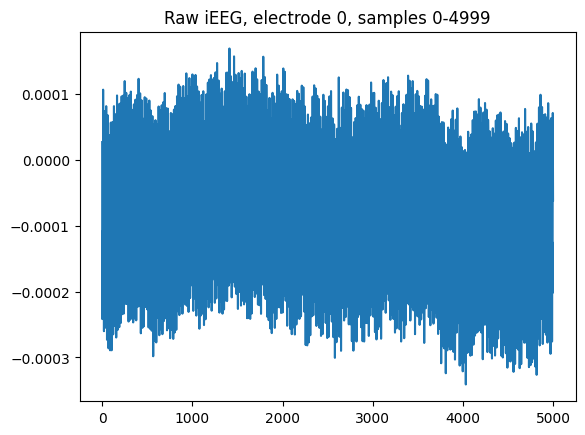

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [8]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   36.1s finished


<RawEDF | MS028_SWB.edf, 276 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

### Photodiode
- examine photodiode 

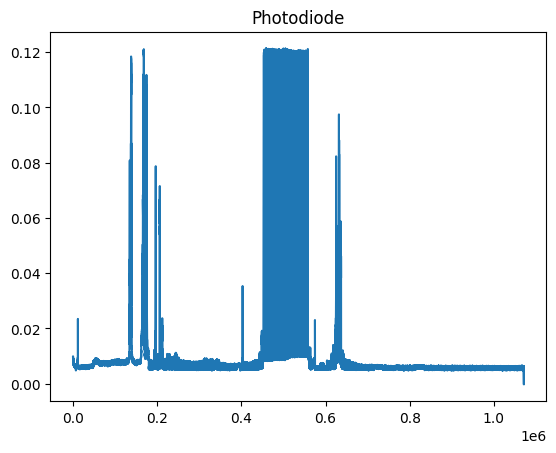

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [10]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/photodiode.fif
[done]


In [11]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS028_SWB.edf, 275 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

### Notch filter line noise

In [12]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    9.2s finished


<RawEDF | MS028_SWB.edf, 275 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

### Anatomical Localization

In [13]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS028_SWB.edf, 275 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

In [14]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LAglT1,mAmyg_L,-22.353151,11.990105,-12.842655,-24.030008,-2.466548,-21.004349,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN,NaN
1,LAglT2,lAmyg_L,-27.152578,11.990105,-11.243587,-29.338226,-2.282588,-19.243495,Gray,Left Ent entorhinal area,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN,NaN
2,LAglT3,Unknown,-31.952006,12.389775,-10.044287,-34.646184,-1.732659,-18.001756,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
3,LAglT4,vId/vIg_L,-36.751433,12.389775,-8.445219,-39.885009,-1.486931,-16.129432,Gray,Left PIns posterior insula,Area Id1,L Superior Temporal Gyrus,L INS,Left superior temporal gyrus A,NaN,NaN
4,LAglT5,A38l_L,-41.550861,12.789446,-7.245918,-45.108698,-0.767422,-14.632926,Gray,Left PP planum polare,Unknown,L Superior Temporal Gyrus,L STG,Left superior temporal gyrus A,NaN,Borderline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,RmOlF9,A44op_R,35.639932,35.170976,11.942894,39.015475,30.366030,0.328881,Gray,Right TrIFG triangular part of the inferior fr...,Unknown,R IFG (p Triangularis),R IFG,Right anterior pars triangularis B,NaN,NaN
162,uLAglT,rHipp_L,-17.953676,11.190765,-14.041956,-19.136886,-3.331668,-22.148985,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN,NaN
163,uLmOlF,A13_L,-7.554916,38.768008,-10.044287,-8.831674,27.220768,-22.979829,Gray,Left GRe gyrus rectus,Area Fo2,L Rectal Gyrus,L OrG,Left frontal orbital 5 A,NaN,NaN
164,uRAglT,mAmyg_R,18.042031,7.993403,-12.043121,19.030036,-5.166208,-20.077131,Gray,Right Amygdala,Amygdala (SF),R ParaHippocampal Gyrus,R Amyg,Right amygdala superior,NaN,NaN


In [15]:
list(elec_locs.label)

['LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMmM1',
 'LCMmM10',
 'LCMmM11',
 'LCMmM12',
 'LCMmM13',
 'LCMmM14',
 'LCMmM2',
 'LCMmM3',
 'LCMmM4',
 'LCMmM5',
 'LCMmM6',
 'LCMmM7',
 'LCMmM8',
 'LCMmM9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaIpS1',
 'LaIpS10',
 'LaIpS11',
 'LaIpS12',
 'LaIpS13',
 'LaIpS14',
 'LaIpS15',
 'LaIpS16',
 'LaIpS2',
 'LaIpS3',
 'LaIpS4',
 'LaIpS5',
 'LaIpS6',
 'LaIpS7',
 'LaIpS8',
 'LaIpS9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RAglT9',
 'RC

In [16]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lalps1', 'lalps2', 'lalps3', 'lalps4', 'lalps5', 'lalps6', 'lalps7', 'lalps8', 'lalps9', 'lalps10', 'lalps11', 'lalps12', 'lalps13', 'lalps14', 'lalps15', 'lalps16', 'c63', 'c64', 'rlms1', 'rlms2', 'rlms3', 'rlms4', 'rlms5', 'rlms6', 'rlms7', 'rlms8', 'rlms9', 'rlms10', 'rlms11', 'rlms12', 'rlms13', 'rlms14', 'rlms15', 'rlms16', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c2

In [17]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [18]:
unmatched_seeg #make sure there are no unmatched names


[]

In [19]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [20]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'lcmmm1': 'lcmmm1',
 'lcmmm2': 'lcmmm2',
 'lcmmm3': 'lcmmm3',
 'lcmmm4': 'lcmmm4',
 'lcmmm5': 'lcmmm5',
 'lcmmm6': 'lcmmm6',
 'lcmmm7': 'lcmmm7',
 'lcmmm8': 'lcmmm8',
 'lcmmm9': 'lcmmm9',
 'lcmmm10': 'lcmmm10',
 'lcmmm11': 'lcmmm11',
 'lcmmm12': 'lcmmm12',
 'lcmmm13': 'lcmmm13',
 'lcmmm14': 'lcmmm14',
 'rcmmm1': 'rcmmm1',
 'rcmmm2': 'rcmmm2',
 'rcmmm3': 'rcmmm3',
 'rcmmm4': 'rcmmm4',
 'rcmmm5': 'rcmmm5',
 'rcmmm6': 'rcmmm6',
 'rcmmm7': 'rcmmm7',
 'rcmmm8': 'rcmmm8',
 'rcmmm9': 'rcmmm9',
 'rcmmm10': 'rcmmm10',
 'rcmmm11': 'rcmmm11',
 'rcmmm12': 'rcmmm12',
 'rcmmm13': 'rcmmm13',
 'rcmmm14': 'rcmmm14',
 'lalps1': 'la

In [21]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS028_SWB.edf, 275 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

In [22]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 80 left sEEG and 82 right sEEG electrodes
We have a total of 162 sEEG electrodes


In [23]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS028_SWB.edf, 275 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

In [24]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS028_SWB.edf, 162 x 1071312 (2142.6 s), ~1.29 GB, data loaded>

In [25]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS028_SWB.edf, 162 x 1071312 (2142.6 s), ~1.29 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 12,
 'laglt': 9,
 'laips': 16,
 'lcmmm': 14,
 'lhplt': 10,
 'lmcms': 10,
 'lmolf': 9,
 'racas': 14,
 'raglt': 9,
 'rcmmm': 14,
 'rhplt': 10,
 'rims': 16,
 'rmcms': 10,
 'rmolf': 9,
 'ulaglt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [31]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['laips6', 'lcmmm8', 'lcmmm9', 'raglt8', 'rmcms8']

<IPython.core.display.Javascript object>


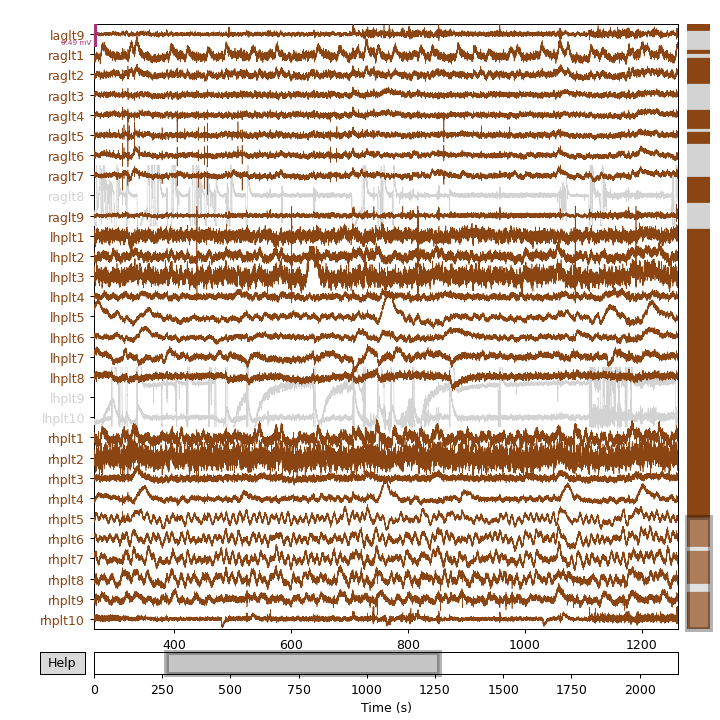

In [33]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=30, scalings=mne_data._data.max()/50)


In [26]:
mne_data.info['bads'] = ['rmolf8',
 'rmolf9',
 'lcmmm11',
 'lmolf3',
 'lmolf4',
 'lmolf5',
 'lmolf6',
 'lmolf7',
 'lmolf9',
 'lcmmm1',
 'lcmmm2',
 'lcmmm3',
 'lcmmm4',
 'lcmmm5',
 'rcmmm1',
 'rcmmm2',
 'rcmmm3',
 'rcmmm4',
 'rcmmm5',
 'rcmmm6',
 'rcmmm7',
 'rcmmm8',
 'rcmmm9',
 'laips3',
 'laips4',
 'laips5',
 'laips6',
 'laips7',
 'laips8',
 'laips9',
 'raglt8',
 'lhplt9',
 'lhplt10']

In [44]:
# mne_data.info['bads'] = ['lmolf9',
#  'rmolf8',
#  'rmolf9',
#  'lcmmm1',
#  'lcmmm2',
#  'lcmmm3',
#  'lcmmm4',
#  'lcmmm5',
#  'rcmmm1',
#  'lcmmm11',
#  'raglt8',
#  'lhplt9',
#  'lhplt10',
#  'laips9'] # old 01 2024

In [27]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 33 items (rmolf8, rmolf9, lcmmm11, lmolf3, lmolf4, lmolf5, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 162 sEEG
 custom_ref_applied: False
 dig: 162 items (162 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 10:31:03 UTC
 nchan: 162
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [28]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [29]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=78, n_times=1071312
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Added the following bipolar channels:
laglt1-laglt2, laglt2-laglt3, laglt3-laglt4, laglt4-laglt5, laglt5-laglt6, laglt6-laglt7, laglt7-laglt8, lcmmm12-lcmmm13, lhplt1-lhplt2, lhplt2-lhplt3, lhplt3-lhplt4, lhplt4-lhplt5, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas8-lacas9, laips1-laips2, laips2-laips10, laips10-laips11, laips11-laips12, laips12-laips13, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms5-lmcms6, lmcms6-lmcms7, lmcms8-lmcms9, lmolf1-lmolf2, raglt1-raglt2, raglt2-raglt3, raglt4-raglt5, raglt5-raglt6, raglt6-raglt7, rcmmm12-rcmmm13, rhplt1-rhplt2, rhplt2-rhplt3, rhplt3-rhplt4, rhplt4-rhplt5, rhplt5-rhplt6, rhplt6-rhplt7, rhplt7-rhplt8, rhplt8-rhplt9, rims1-rims2,

In [30]:
mne_data_bp_reref

<RawEDF | MS028_SWB.edf, 78 x 1071312 (2142.6 s), ~637.7 MB, data loaded>

In [31]:
mne_data_bp_reref.ch_names

['laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt4-laglt5',
 'laglt5-laglt6',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'lcmmm12-lcmmm13',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas8-lacas9',
 'laips1-laips2',
 'laips2-laips10',
 'laips10-laips11',
 'laips11-laips12',
 'laips12-laips13',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms5-lmcms6',
 'lmcms6-lmcms7',
 'lmcms8-lmcms9',
 'lmolf1-lmolf2',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt4-raglt5',
 'raglt5-raglt6',
 'raglt6-raglt7',
 'rcmmm12-rcmmm13',
 'rhplt1-rhplt2',
 'rhplt2-rhplt3',
 'rhplt3-rhplt4',
 'rhplt4-rhplt5',
 'rhplt5-rhplt6',
 'rhplt6-rhplt7',
 'rhplt7-rhplt8',
 'rhplt8-rhplt9',
 'rims1-rims2',
 'rims2-rims3',
 'rims3-rims4',
 'rims4-rims5',
 'rims5-rims6',
 'rims8-rims9',
 'rims9-rims10',
 'rims10-rims11',
 'rims11-rims12',
 'rims12-rims13',
 'rims13-rims14',
 'racas1-rac

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


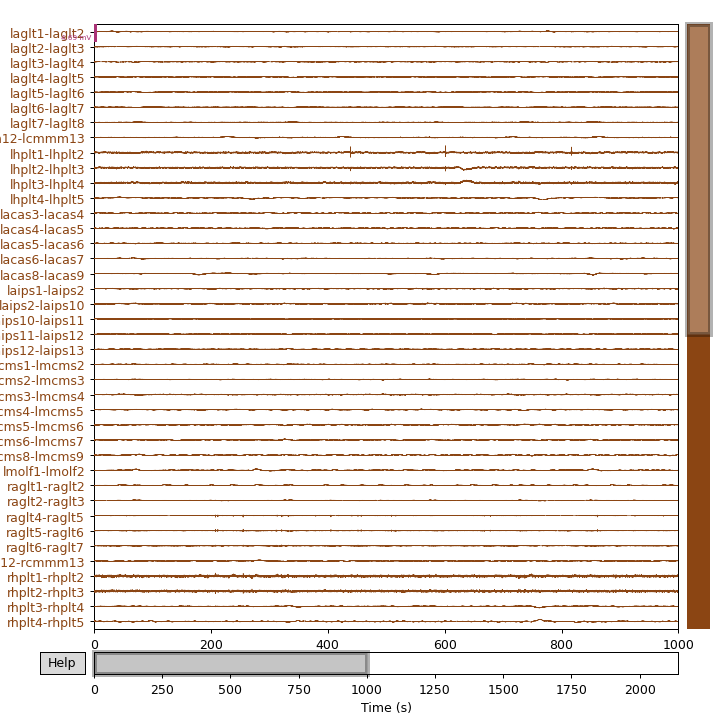

In [56]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


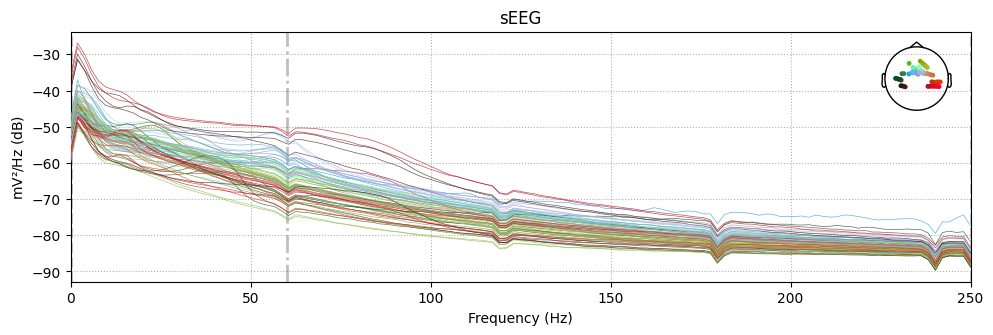

In [32]:
mne_data_bp_reref.compute_psd().plot()

In [33]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/bp_ref_ieeg.fif
[done]


## Save mne_data

In [34]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [35]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [36]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/photodiode.fif...
Isotrak not found
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Reading 0 ... 1071311  =      0.000 ...  2142.622 secs...


In [37]:
len(beh_ts)

150

In [38]:
photodiode_data

<Raw | photodiode.fif, 1 x 1071312 (2142.6 s), ~8.2 MB, data loaded>

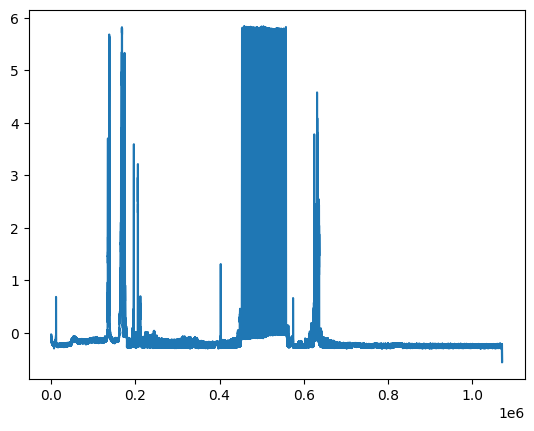

In [122]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# plt.plot(scipy.stats.zscore(photodiode_data._data[0,410000:600000]))
plt.show()
# plt.ylim([5,6])
# plt.xlim([900000,1100000])

In [935]:
### Photodiode alignment
smoothSize=11
windSize=15
height=4.25

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

2 blocks
..

found matches for 15 of 36 pulses


In [936]:
print(slope,offset,height) ##### WRONG!!! #04082024

1.0040041443778296 18.28958336435994 4.25


1.0040041443778296 18.28958336435994


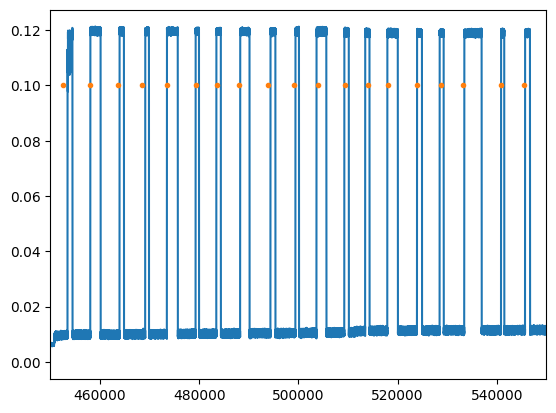

In [938]:
pulses = [(x*slope + offset) for x in beh_ts]
print(slope,offset)
plt.plot(photodiode_data._data[0,:])
# plt.plot(pulses)
plt.plot(np.array(pulses)*photodiode_data.info['sfreq'], 
         0.1 * np.ones_like(np.array(pulses) * photodiode_data.info['sfreq']),'.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([450000,550000])
# plt.ylim([5,6])
plt.show()


In [866]:
#### verify photodiode alignment
    # requires newer functions from new sync utils package (older version used here)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def matched_pulses(beh_pulse, neural_pulse):
    """
    Compute the slope and offset of the linear regression between two sets of pulse timestamps.

    Parameters:
    beh_pulse (array-like): The timestamps of the behavioral pulses.
    neural_pulse (array-like): The timestamps of the neural pulses.

    Returns:
    tuple: A tuple containing the slope, offset, and correlation coefficient of the linear regression.

    Note:     Idea is similar to this: https://github.com/mne-tools/mne-python/blob/main/mne/preprocessing/realign.py#L13-L111

    """
    bfix = beh_pulse[0]
    res = scipy.stats.linregress(beh_pulse-bfix, neural_pulse)
    slope = res[0]
    offset = res[1]
    offset = offset - bfix*slope
    rval = res[2]

    return slope, offset, rval

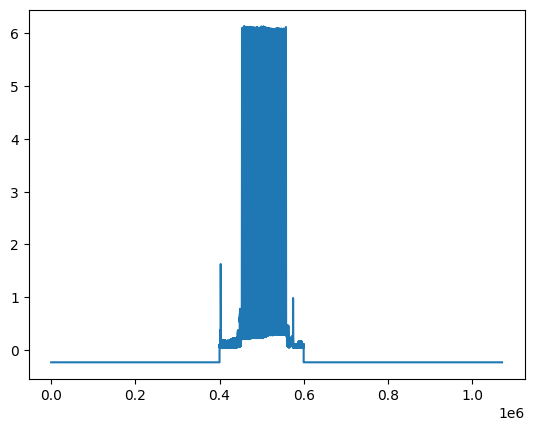

In [867]:
temp_diode = photodiode_data.copy()
# temp_data = temp_diode._data[0,:]
# temp_diode._data[temp_diode._data>0.8] = -2
temp_diode._data[0,0:400000] = np.min(temp_diode._data)
temp_diode._data[0,600000:] = np.min(temp_diode._data)

plt.plot(scipy.stats.zscore(temp_diode._data[0,:]))
# plt.plot(scipy.stats.zscore(photodiode_data._data[0,410000:600000]))
plt.show()

In [959]:
neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=45, height=4.25)
neural_ts.shape


(21,)

In [485]:
# # pulses = [(x*slope + offset) for x in beh_ts]
# # moving_average
# neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=45, height=5)
# neural_ts.shape


(21,)

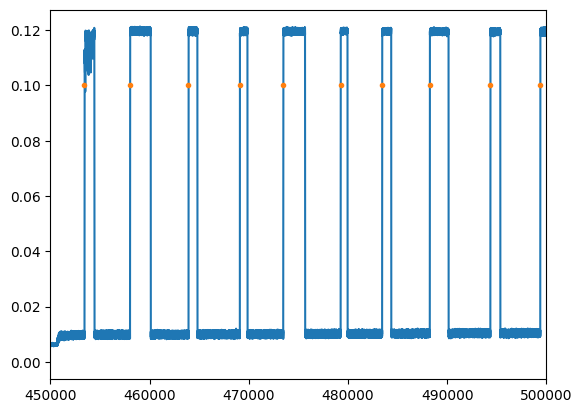

In [961]:
plt.plot(photodiode_data._data[0,:])
plt.plot(neural_ts * photodiode_data.info['sfreq'], 0.1 * np.ones_like(neural_ts * photodiode_data.info['sfreq']),'.')
plt.xlim([450000,500000])
# plt.ylim([5,6])
plt.show()


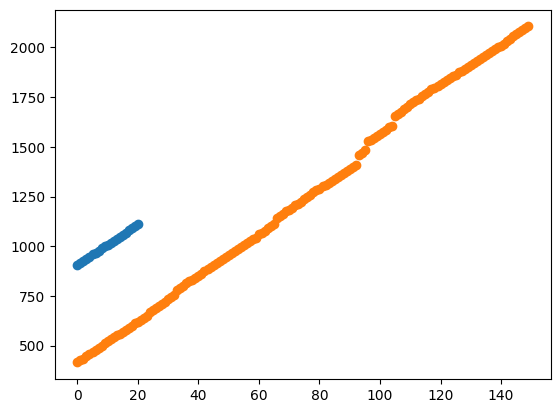

In [962]:
plt.plot(neural_ts, 'o')
plt.plot(beh_ts,'o')
plt.show()


In [963]:
nwin = len(beh_ts) - len(neural_ts)
rvals = []
slopes = [] 
offsets = []
for i in range(nwin+1):
    slope, offset, rval = matched_pulses(beh_ts[i:len(neural_ts)+i].values, neural_ts)
    rvals.append(rval)
    slopes.append(slope)
    offsets.append(offset)
rvals = np.array(rvals)
offsets = np.array(offsets)
slopes = np.array(slopes)

In [964]:
np.argmax(rvals)

43

In [965]:
slope_diff = (np.abs(slopes - 1))
slope_diff
np.argmin(slope_diff)

43

In [966]:
list(zip(rvals,slopes,offsets))

[(0.9989986209391918, 0.9882288355920493, 495.2079818470751),
 (0.9992496897132416, 0.9914729371744995, 483.337562393785),
 (0.9989989914267965, 0.9965734040914643, 470.4782486072039),
 (0.9988945078306904, 1.0042421687408338, 456.09372847669704),
 (0.9992016928955437, 0.9940273708074941, 451.2284399025215),
 (0.9990759813410723, 0.9883998069458716, 443.85608620848524),
 (0.9991627332247033, 0.9827169940177314, 436.58455987135693),
 (0.9995632895105393, 0.9777109047792493, 429.0352509487208),
 (0.9991212139864357, 0.9721166048991118, 421.9716819638591),
 (0.9988437047569433, 0.9678032062988299, 414.28286822336133),
 (0.9989385650757497, 0.9561235163734408, 411.2893565953205),
 (0.9986006990035501, 0.9467754213103575, 407.1854344288563),
 (0.9984923032076715, 0.9406112797424365, 401.1135604166461),
 (0.9985341189843298, 0.9165900442641423, 406.2595103890111),
 (0.9980997803491743, 0.8967573158470385, 409.03383029133784),
 (0.99834898246894, 0.8831654354931335, 407.9525363061818),
 (0.99

In [967]:
# rvals[np.argmax(rvals)]
rvals[np.argmin(slope_diff)]

0.9999479716056228

In [968]:
# slopes[np.argmax(rvals)]
slopes[np.argmax(rvals)]

1.001000530080962

In [969]:
# offsets[np.argmax(rvals)]
offsets[np.argmin(slope_diff)]

21.436464981036465

In [970]:
offset = offsets[np.argmin(slope_diff)]
slope = slopes[np.argmin(slope_diff)]
print(slope,offset)

1.001000530080962 21.436464981036465


In [971]:
pulses = [(x*slope + offset) for x in beh_ts]

In [972]:
photodiode_data.info['sfreq']

500.0

1.001000530080962 21.436464981036465


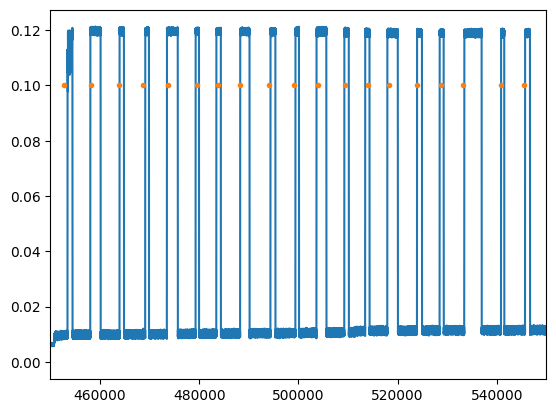

In [973]:
# pulses = [(x*slope + offset) for x in beh_ts]
print(slope,offset)
plt.plot(photodiode_data._data[0,:])
# plt.plot(pulses)
plt.plot(np.array(pulses)*photodiode_data.info['sfreq'], 
         0.1 * np.ones_like(np.array(pulses) * photodiode_data.info['sfreq']),'.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([450000,550000])
# plt.ylim([5,6])
plt.show()


## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [974]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [975]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [977]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
print(slope, offset)

1.001000530080962 21.436464981036465


In [978]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/bp_ref_ieeg.fif...
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Reading 0 ... 1071311  =      0.000 ...  2142.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  75 out of  78 | elapsed:    3.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    4.0s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 78 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/bp_ref_ieeg.fif...
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Reading 0 ... 1071311  =      0.000 ...  2142.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  75 out of  78 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    3.5s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 78 columns


In [979]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~134.1 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~312.7 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [980]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']

In [981]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 100 columns
Replacing existing metadata with 100 columns


In [982]:
epochs_all_evs[event].metadata

,laglt1-laglt2,laglt2-laglt3,laglt3-laglt4,laglt4-laglt5,laglt5-laglt6,laglt6-laglt7,laglt7-laglt8,lcmmm12-lcmmm13,lhplt1-lhplt2,lhplt2-lhplt3,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.30,1.30,0.00,0.0,1.30,1.30,-1.90,-1.90,0.000,0.000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.75,2.25,0.00,0.0,3.75,2.25,-1.50,0.00,1.875,0.000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.20,-0.20,-0.20,-0.2,0.00,0.00,0.00,0.00,0.000,0.000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.26,0.86,0.00,0.0,1.26,0.86,0.00,0.40,0.630,0.000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.99,0.59,0.00,0.0,0.99,0.59,0.00,0.40,0.495,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,...,-1.76,-0.80,-1.76,-0.8,0.00,0.00,0.96,0.00,0.000,-0.880
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,...,0.54,0.54,0.00,0.0,0.54,0.54,-0.84,-0.84,0.000,0.000
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.24,0.74,0.00,0.0,1.24,0.74,0.00,0.50,0.620,0.000
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.49,-0.60,-1.49,-0.6,0.00,0.00,1.49,0.60,0.000,-0.745


### Save raw epoched data 

In [983]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [984]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [985]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [986]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [987]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [988]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 78, ~1.31 GB>}

In [989]:
power_epochs = {}

In [990]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
Adding metadata with 100 columns


In [991]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 78, ~6.54 GB>

In [992]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [993]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04082024


In [231]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)
# del epochs_all_baseline, power_epochs, plot_data

In [994]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()


21.436464981036465
